In [4]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, expon, binom, norm
from scipy.stats import gaussian_kde
from utils import *
from copy import copy

sns.set_style("whitegrid")

In [168]:
def total_rev(printed, orders):
    return min(printed, np.sum(orders)) * 10

def order_cost(printed):
    if printed >= 100:
        c = 4.5
    else:
        c = 5
    return printed * c

def inventory_cost(printed, orders):
    return max(0, printed - np.sum(orders)) * 2

def opportunity_cost(printed, orders):
    wks = len(orders)
    total_orders = np.sum(orders)
    for i, n in enumerate(np.cumsum(orders)):
        if printed < n:
            return (wks - i) * 50
    return 0

def compute_profit(printed, orders):
    return (
        total_rev(printed, orders)
        - order_cost(printed)
        - inventory_cost(printed, orders)
        - opportunity_cost(printed, orders)
    )

Mean lambda = 9.33


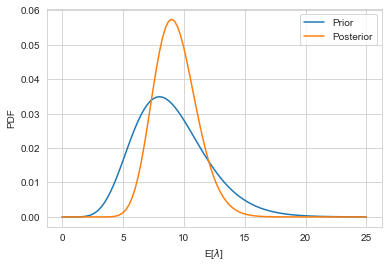

In [164]:
alpha = 9
lam_qs = np.linspace(0, 25, 101)
lam_prior = normalize_dist(pd.Series(gamma(alpha).pdf(lam_qs), index=lam_qs))

# two updates on w1 w2 data
lam_posterior = update_prior(lam_prior, poisson.pmf(k=10, mu=lam_qs))
lam_posterior = update_prior(lam_posterior, poisson.pmf(k=9, mu=lam_qs))

print('Mean lambda = {:.2f}'.format(dist_mean(lam_posterior)))
lam_prior.plot(label='Prior')
lam_posterior.plot(label='Posterior')
plt.xlabel('E[$\lambda$]')
plt.ylabel('PDF')
_ = plt.legend()
plt.show()

Optimal Printed # = 80 & Profits = $257.13


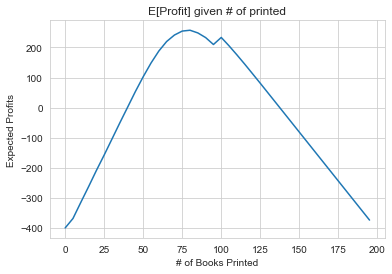

In [167]:
def compute_Eprofit(printed, orders_simu):
    return np.mean([compute_profit(printed, s) for s in orders_simu])

    
np.random.seed(17)
printed_lst = np.arange(0, 200, 5)

simu = [
    poisson.rvs(l, size=8)
    for l in np.random.choice(lam_posterior.index.values, size=1000, p=lam_posterior.values)
]
sr_Eprofit = pd.Series(
    [compute_Eprofit(p, simu) for p in printed_lst],
    index=printed_lst
)

print('Optimal Printed # = {:.0f} & Profits = ${:.2f}'.format(sr_Eprofit.idxmax(), sr_Eprofit.max()))
sr_Eprofit.plot()
plt.xlabel('# of Books Printed')
plt.ylabel('Expected Profits')
plt.title('E[Profit] given # of printed')
plt.show()